In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim


import cv2

# Logger

In [2]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueezeNet Classifier. First Test.')

# Config

In [3]:
#CLASSES = ["smoke", "fire"]
CLASSES = ["fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [4]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )[:8]
    
        self.images_path, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
                ones_array = np.ones((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, ones_array):
                            break
                        elif class_id == 1:
                            label_array[0] = 1.
                        else:
                            continue

                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.0)
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        else:        
            img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
            img = (img / 255.0)
            img = torch.tensor(img, dtype=torch.float32)
            img = img.permute(2, 0, 1)
        
        return img, label

### View Dataset

In [5]:
#ds_dir = '../../ds2fire/dfire_yolo/'
ds_dir = '../pets/pets/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', 'images']
val dir: ['labels', 'images']


### Transform

In [6]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [7]:
view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             transform=view_transform)
                             #transform=None)
VIEW_BATCH_SIZE = 4
view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
Val dataset length: 8


# Plot Dataset Pictures

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


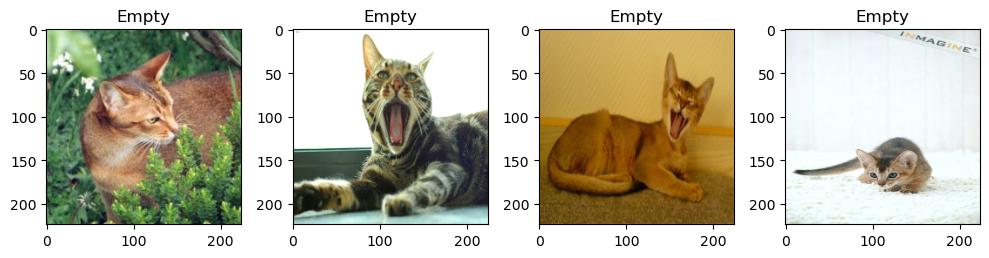

In [8]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(1,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(1, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx] == 1:
            title += "Fire"
        else:
            title += "Empty"
        plt.title(title)
        if (idx == 3):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: Optim Bed

In [9]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 128
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.smoke = nn.Sequential(
        #     nn.Dropout(p=0.2),
        #     nn.Linear(in_features=self.last_channels, out_features=1)
        # )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        print(f'Input: {x}')
        x = self.model(x)
        print(f'X before avg pooling: {x}')
        x = self.pool(x)
        print(f'X after avg pooling: {x}')
        x = torch.flatten(x, start_dim=1)
        print(f'X before linnear:\n{x}')
        # x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        # print(f'X after linnear:\n{x}')
        x = self.fire(x)
        x = torch.sigmoid(x)
        return x

# Test CNN

In [10]:
class TEST_CNN(nn.Module):
    def __init__(self):
        super(TEST_CNN, self).__init__()
        
        self.model = self.__create_model__()
        
    def __create_model__(self):
        model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features=24, out_features=1),
            nn.Sigmoid(),
 
        )
        return model        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        self.bce = nn.BCELoss(reduction='mean')
        self.mse = nn.MSELoss(reduction='mean')
        self.eps = 1e-10
        
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        print(f'Ground trunth: {ground_truth}')
        print(f'Predictions: {predictions}')

        fire_loss = self.bce(ground_truth + self.eps, predictions + self.eps)
        #fire_loss = self.mse(ground_truth, predictions)
        self.fire_loss = fire_loss.item()
              
        return fire_loss

    def get_last_losses(self):     
        return self.fire_loss

# Train Loop

In [12]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        fire_losses.append(last_losses)
        
        print(f'Train loss: {train_loss}')
        print(f'Train loss: {train_losses}')


    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    
    return (train_mean_loss, 
            fire_mean_loss)

# Validation Loop

In [13]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        fire_losses.append(last_losses)

    logger.info("\nTRAIN losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    
    return (val_mean_loss, 
            fire_mean_loss)

# Hyperparameters

In [14]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"
MODEL = "TEST_CNN"


LEARNING_RATE = 5e-4
#LEARNING_RATE = 0.1
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
BATCH_SIZE = 4 
#WEIGHT_DECAY = 1e-4
WEIGHT_DECAY = 0
EPOCHS = 10
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_fire_loss = []

epochs_plot = []

# Main Function

In [15]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if MODEL == "BED":
        print("Using BED Classifier")
        logger.info("Using BED Classifier")
        model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
    elif MODEL == "SQUEEZE":
        print("Using Squeeze Classifier")
        logger.info("Using Squeeze Classifier")
        model = SqueezeNet_CLASSIFIER().to(DEVICE)   
    elif MODEL == "TEST_CNN":
        print("Using Test CNN Classifier")
        logger.info("Using Test CNN Classifier")
        model = TEST_CNN().to(DEVICE)           
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")
    
    # Check model shape
    in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
    in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
    out_test = model(in_rand)
    print(f'Model shape is {out_test.shape}')
    print(f'BED Model Arquitecture\n{model}')
    logger.info(f'Model shape is {out_test}')
    logger.info(f'BED Model Arquitecture\n{model}')
    
    
    optimizer = optim.Adam(model.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=WEIGHT_DECAY)
    
    # optimizer = torch.optim.SGD(model.parameters(), 
    #                             lr=LEARNING_RATE,
    #                             momentum=0.9, 
    #                             weight_decay=WEIGHT_DECAY, 
    #                             nesterov=True)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.8, 
                                                     patience=2, 
                                                     threshold=0.1, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-6)
    
    # MODEL PARAMETERS
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')
    logger.info(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(model.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    logger.info(f'Total parameters = {n_params}\n')
    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    train_transform = A.Compose([
            # A.HorizontalFlip(p=0.5),
            # A.OneOf([
            #     A.RandomBrightnessContrast(p=0.4),
            #     A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            #     A.Blur(blur_limit=(3,3), p=0.3),
            #     A.CLAHE(clip_limit=2.0, p=0.3),
            #     A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            # ], p=0.9),
            # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.Resize(IMG_H, IMG_W, p=1),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
            ToTensorV2(p=1),
        ]
    )
    
    # TRAIN DATASET
    print("\nTRAIN DFIRE dataset")
    logger.info("\nTRAIN DFIRE dataset")
    train_dataset = DFireDataset(img_h = IMG_H,
                                 img_w = IMG_W,
                                 img_dir = TRAIN_IMG_DIR,
                                 label_dir = TRAIN_LABEL_DIR,
                                 num_classes=N_CLASSES,
                                 #transform=train_transform)
                                 transform=None)

    print(f'Train dataset len: {len(train_dataset)}')
    logger.info(f'Train dataset len: {len(train_dataset)}')

    
    # VALIDATION DATASET
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
        ]
    )
    
    print("\nTEST DFire dataset")
    logger.info("\nTEST DFire dataset")
    val_dataset = DFireDataset(img_h = IMG_H,
                               img_w = IMG_W,
                               img_dir = VAL_IMG_DIR,
                               label_dir = VAL_LABEL_DIR,
                               num_classes = N_CLASSES,
                               #transform=val_transform)
                               transform=None)

    print(f'Test dataset len: {len(val_dataset)}')
    logger.info(f'Test dataset len: {len(val_dataset)}')
    
    
    # LOADERS
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY,
                            shuffle=False,
                            drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Pretrained Weights")
            logger.info("Pretrained Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, fire_loss = train_fn(loader=train_loader, 
                                                     model=model, 
                                                     optimizer=optimizer, 
                                                     loss_fn=loss_fn,
                                                     device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_fire_loss.append(fire_loss)
        
        # VALIDATING
        with torch.no_grad():
            val_loss, fire_loss = eval_fn(loader=val_loader, 
                                                      model=model,                         
                                                      loss_fn=loss_fn,
                                                      device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_fire_loss.append(fire_loss)
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Train Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main execute

In [16]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    main()

Starting script

Device: cpu
Learning Rate: 0.0005
Weight Decay: 0
Batch Size: 4
IMG DIMS: (224, 224)
W: 224
H: 224
Using Test CNN Classifier
Model shape is torch.Size([4, 1])
BED Model Arquitecture
TEST_CNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU()
    (7): AdaptiveAvgPool2d(output_size=1)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=24, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(



Trainable parameters = 15577
Total parameters = 15577

Loss Function: BCE

TRAIN DFIRE dataset
DFire Removed wrong images: 0
Train dataset len: 8

TEST DFire dataset
DFire Removed wrong images: 0
Test dataset len: 8

***Start Training: 17:07:22


=== EPOCH 0/9 ===
Learning Rate = 0.0005



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4933],
        [0.4650],
        [0.5095],
        [0.5101]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it]

Train loss: 11.385380744934082
Train loss: [11.385380744934082]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5244],
        [0.4840],
        [0.4478],
        [0.4879]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train loss: 11.191102981567383
Train loss: [11.385380744934082, 11.191102981567383]
Total Loss  |Fire Loss   
------------ ------------
11.288      |11.288      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4936],
        [0.5059],
        [0.5084],
        [0.5109]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5120],
        [0.5102],
        [0.5084],
        [0.5020]])
Total Loss  |Fire Loss   
------------ ------------
11.661      |11.661      




Saving model with new best validation loss: 11.661

=== EPOCH 1/9 ===
Learning Rate = 0.0005



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4748],
        [0.4407],
        [0.4392],
        [0.5595]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it]

Train loss: 11.018930435180664
Train loss: [11.018930435180664]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4857],
        [0.4807],
        [0.4233],
        [0.4977]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train loss: 10.864776611328125
Train loss: [11.018930435180664, 10.864776611328125]
Total Loss  |Fire Loss   
------------ ------------
10.942      |10.942      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5000],
        [0.5111],
        [0.5131],
        [0.5143]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5142],
        [0.5156],
        [0.5109],
        [0.5071]])
Total Loss  |Fire Loss   
------------ ------------
11.761      |11.761      




=== EPOCH 2/9 ===
Learning Rate = 0.0005



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4382],
        [0.5450],
        [0.4997],
        [0.3928]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

Train loss: 10.7975492477417
Train loss: [10.7975492477417]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5182],
        [0.3869],
        [0.4179],
        [0.5418]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train loss: 10.73440170288086
Train loss: [10.7975492477417, 10.73440170288086]
Total Loss  |Fire Loss   
------------ ------------
10.766      |10.766      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4960],
        [0.5087],
        [0.5115],
        [0.5123]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5124],
        [0.5139],
        [0.5091],
        [0.5046]])
Total Loss  |Fire Loss   
------------ ------------
11.709      |11.709      




=== EPOCH 3/9 ===
Learning Rate = 0.0005



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5052],
        [0.4836],
        [0.5232],
        [0.3577]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it]

Train loss: 10.762152671813965
Train loss: [10.762152671813965]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4075],
        [0.5433],
        [0.4858],
        [0.4291]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Train loss: 10.739847183227539
Train loss: [10.762152671813965, 10.739847183227539]
Total Loss  |Fire Loss   
------------ ------------
10.751      |10.751      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4877],
        [0.5043],
        [0.5084],
        [0.5089]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5098],
        [0.5102],
        [0.5059],
        [0.4989]])
Total Loss  |Fire Loss   
------------ ------------
11.611      |11.611      




Saving model with new best validation loss: 11.611

=== EPOCH 4/9 ===
Learning Rate = 0.0004



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.3977],
        [0.4926],
        [0.3843],
        [0.5244]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it]

Train loss: 10.355667114257812
Train loss: [10.355667114257812]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.3905],
        [0.5116],
        [0.4818],
        [0.4462]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Train loss: 10.534542083740234
Train loss: [10.355667114257812, 10.534542083740234]
Total Loss  |Fire Loss   
------------ ------------
10.445      |10.445      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4827],
        [0.5022],
        [0.5068],
        [0.5074]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5086],
        [0.5082],
        [0.5036],
        [0.4953]])
Total Loss  |Fire Loss   
------------ ------------
11.556      |11.556      




Saving model with new best validation loss: 11.556

=== EPOCH 5/9 ===
Learning Rate = 0.0004



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4175],
        [0.4357],
        [0.5126],
        [0.4274]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.21s/it]

Train loss: 10.323019981384277
Train loss: [10.323019981384277]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4737],
        [0.4109],
        [0.4543],
        [0.4588]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train loss: 10.348382949829102
Train loss: [10.323019981384277, 10.348382949829102]
Total Loss  |Fire Loss   
------------ ------------
10.336      |10.336      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4784],
        [0.5010],
        [0.5064],
        [0.5072]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5084],
        [0.5075],
        [0.5024],
        [0.4927]])
Total Loss  |Fire Loss   
------------ ------------
11.524      |11.524      




Saving model with new best validation loss: 11.524

=== EPOCH 6/9 ===
Learning Rate = 0.0004



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4606],
        [0.3575],
        [0.4796],
        [0.4850]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it]

Train loss: 10.262495040893555
Train loss: [10.262495040893555]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4694],
        [0.4084],
        [0.4196],
        [0.4972]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Train loss: 10.330353736877441
Train loss: [10.262495040893555, 10.330353736877441]
Total Loss  |Fire Loss   
------------ ------------
10.296      |10.296      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4728],
        [0.5003],
        [0.5068],
        [0.5083]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5092],
        [0.5080],
        [0.5020],
        [0.4904]])
Total Loss  |Fire Loss   
------------ ------------
11.506      |11.506      




Saving model with new best validation loss: 11.506

=== EPOCH 7/9 ===
Learning Rate = 0.0004



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4727],
        [0.4170],
        [0.4246],
        [0.4959]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it]

Train loss: 10.420526504516602
Train loss: [10.420526504516602]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4855],
        [0.4472],
        [0.3719],
        [0.4842]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train loss: 10.296831130981445
Train loss: [10.420526504516602, 10.296831130981445]
Total Loss  |Fire Loss   
------------ ------------
10.359      |10.359      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4677],
        [0.4999],
        [0.5080],
        [0.5098]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5105],
        [0.5094],
        [0.5023],
        [0.4885]])
Total Loss  |Fire Loss   
------------ ------------
11.502      |11.502      




Saving model with new best validation loss: 11.502

=== EPOCH 8/9 ===
Learning Rate = 0.00032



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.3726],
        [0.4766],
        [0.4802],
        [0.4483]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.03s/it]

Train loss: 10.233613967895508
Train loss: [10.233613967895508]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4794],
        [0.4002],
        [0.4656],
        [0.3882]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Train loss: 9.977790832519531
Train loss: [10.233613967895508, 9.977790832519531]
Total Loss  |Fire Loss   
------------ ------------
10.106      |10.106      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4655],
        [0.4999],
        [0.5100],
        [0.5104]])


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5117],
        [0.5111],
        [0.5020],
        [0.4885]])
Total Loss  |Fire Loss   
------------ ------------
11.510      |11.510      




=== EPOCH 9/9 ===
Learning Rate = 0.00032



Training:   0%|          | 0/2 [00:00<?, ?it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4604],
        [0.4004],
        [0.3924],
        [0.4715]], grad_fn=<SigmoidBackward0>)


Training:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it]

Train loss: 9.928007125854492
Train loss: [9.928007125854492]
Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4815],
        [0.4382],
        [0.4747],
        [0.3746]], grad_fn=<SigmoidBackward0>)


Training: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train loss: 10.183266639709473
Train loss: [9.928007125854492, 10.183266639709473]
Total Loss  |Fire Loss   
------------ ------------
10.056      |10.056      



Validating:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.4642],
        [0.4997],
        [0.5121],
        [0.5105]])


Validating: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

Ground trunth: tensor([[0.],
        [0.],
        [0.],
        [0.]])
Predictions: tensor([[0.5125],
        [0.5128],
        [0.5013],
        [0.4889]])
Total Loss  |Fire Loss   
------------ ------------
11.519      |11.519      




***Script finished: 17:07:54

Time elapsed: 0:00:32.529213
